In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy.interpolate
import matplotlib.pyplot as plt

# The Black Scholes Formula
# CallorPut
# S - Stock price (known)
# K - Strike price (known)
# T - Time to maturity (known)
# r - Riskfree interest rate (can be found)
# d - Dividend yield (KNown(?))
# v - Volatility (given)

def BlackScholes(CallorPut, S, K, T, r, d, v):
    d1 = (np.log(float(S)/K)+((r-d) + v*v/2.)*T)/(v*np.sqrt(T))
    d2 = d1 - v*np.sqrt(T)
    
    if CallorPut == 'Call':
        return S*np.exp(-d*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*np.exp(-d*T)*norm.cdf(-d1)
    
##THIS WORKS DON'T TOUCH np

#bring in options data 
options = pd.read_csv('opt_port.csv')

opt_list=(0,1,2,3,4,5,6)
options['BS_Price'] = ""

for x in opt_list:
    maturity = (options.iloc[x, 1]/365)
    options.iloc[x, 11] = BlackScholes( options.iloc[x, 4], #callorput
                 options.loc[x, 'Spot'], #spot
                 options.loc[x, 'Strike'], #Strike
                 maturity, # T 
                 options.iloc[x, 2], #RF rate
                 0, #div yield
                 options.iloc[x, 8] #vol
                )
    
options

,Maturity,Days,RF rate,Underlying,PutorCall,BoughtSold,Number of Shares,Strike,Vol,Div Yield,Spot,BS_Price
0,9/12/2019,129,0.010187,BHP,Call,Bought,20000,39.0,0.2600,0.0414,38.78,2.35171
1,8/03/2020,219,0.009705,CBA,Put,Bought,15000,75.0,0.2798,0.0580,81.88,3.70921
2,12/04/2020,254,0.009443,CBA,Call,Bought,15000,75.0,0.2798,0.0580,81.88,11.5326
3,4/05/2020,276,0.009289,WESP,Put,Bought,25000,38.1,0.3056,0.0567,38.86,3.56053
4,7/08/2020,371,0.009026,WESP,Call,Bought,20000,39.0,0.3298,0.0567,38.86,5.22559
5,6/11/2020,462,0.008754,WPL,Call,Sold,10000,35.0,0.2845,0.0603,33.81,3.95955
6,6/12/2020,492,0.008665,WPL,Put,Bought,15000,33.0,0.2700,0.0603,33.81,3.56697


In [2]:
'''#bring in share data 
sharedata = pd.read_csv('RSKMShares.csv', index_col = 'Date', parse_dates = True)
sharedata.columns = [ 'ASX200', 'BHP', 'RIO', 'CBA', 'WESP', 'WPL', 'NAB', 'TLS']

#Get option data only 
opt_list_name = ('BHP', 'CBA', 'WESP', 'WPL')

Hist_opt_returns = pd.DataFrame()
for x in opt_list_name:
    Hist_opt_returns[x] = sharedata[x]
    
#calc returns
Hist_opt_returns = np.log(Hist_opt_returns).diff()
#drop first row NaN 
Hist_opt_returns = (Hist_opt_returns.drop(Hist_opt_returns.index[0]))

#simulated price change 
Sim_price_change = Hist_opt_returns * [38.78, 81.88, 38.86, 33.81]

#Spot + sim price change 
HS_Sim_Price = Sim_price_change + [38.78, 81.88, 38.86, 33.81]

#add in rows for CBA, WES & WPL as both have 2 options 
HS_Sim_Price.insert(2, 'CBA_2', HS_Sim_Price['CBA'])
HS_Sim_Price.insert(4, 'WESP_2', HS_Sim_Price['WESP'])
HS_Sim_Price.insert(6, 'WPL_2', HS_Sim_Price['WPL'])

HS_Sim_Price.head()'''

,BHP,CBA,CBA_2,WESP,WESP_2,WPL,WPL_2
Date,,,,,,,
2009-01-02,38.957919,82.725633,82.725633,38.206745,38.206745,34.358267,34.358267
2009-01-05,40.089255,80.180197,80.180197,39.513255,39.513255,34.233375,34.233375
2009-01-06,38.865714,84.333588,84.333588,39.671725,39.671725,34.553687,34.553687
2009-01-07,39.865673,80.422318,80.422318,41.098803,41.098803,33.949827,33.949827
2009-01-08,36.514407,80.769452,80.769452,37.250478,37.250478,31.705231,31.705231


In [48]:
#Chol matrix + random numbers 
share_log_returns = pd.DataFrame()
share_n = (0,1,2,3,4,5,6)
sharelist = ('BHP', 'RIO', 'CBA', 'WESP', 'WPL', 'NAB', 'TLS')
for x in sharelist:
    
    share_log_returns[x] = np.log(sharedata[x]).diff()
    
cov_matrix  = share_log_returns.cov()

chol = np.linalg.cholesky(cov_matrix)

#random numbers
rand_numbers = pd.DataFrame()
n_sims = 10000

for x in share_n:
    rand_numbers[x] = np.random.normal(0, 1, n_sims)
    
sim = []
outtest = []
for x in list(range(0, n_sims)):
    outtest = chol.dot(np.array(rand_numbers.loc[x, :]))
    sim.append(outtest)
    
#Calc simulated prices 
MC_sim_returns = pd.DataFrame(sim)
MC_sim_returns.columns = ['BHP', 'RIO', 'CBA', 'WESP', 'WPL', 'NAB', 'TLS']

MC_sim_price_change = MC_sim_returns * [38.78,94.77,81.88,38.86,33.81,28.51,3.98]

MC_sim_price = MC_sim_price_change + [38.78,94.77,81.88,38.86,33.81,28.51,3.98]

#Options
opt_list_name = ('BHP', 'CBA', 'WESP', 'WPL')

MC_opt_price = pd.DataFrame()
for x in opt_list_name:
    MC_opt_price[x] = MC_sim_price[x]
    
#insert clone columns
MC_opt_price.insert(2, 'CBA_2', MC_opt_price['CBA'])
MC_opt_price.insert(4, 'WESP_2', MC_opt_price['WESP'])
MC_opt_price.insert(6, 'WPL_2', MC_opt_price['WPL'])

In [22]:
MC_opt_price

,BHP,CBA,CBA_2,WESP,WESP_2,WPL,WPL_2
0,39.763534,82.031967,82.031967,38.307318,38.307318,34.514335,34.514335
1,39.447326,81.759707,81.759707,38.159797,38.159797,33.207293,33.207293
2,38.879129,81.240338,81.240338,38.789459,38.789459,33.299839,33.299839
3,39.535143,82.048244,82.048244,37.769304,37.769304,34.410384,34.410384
4,39.543943,83.411005,83.411005,39.537383,39.537383,35.054540,35.054540
5,39.874329,83.384397,83.384397,40.043117,40.043117,34.792483,34.792483
6,38.724144,80.623142,80.623142,38.410643,38.410643,33.402964,33.402964
7,37.202693,80.481059,80.481059,38.360452,38.360452,32.578063,32.578063
8,39.452534,82.816509,82.816509,39.755555,39.755555,33.767941,33.767941
9,39.797414,83.460418,83.460418,39.115698,39.115698,34.969098,34.969098


In [59]:
#Historical simulation of option prices 
opt_list=(0,1,2,3,4,5,6)
BS_MC_Sim = pd.DataFrame()
hist = list(range(0, 9999))

for y in hist:
    
    for x in opt_list:
        
        maturity = (options.iloc[x, 1]/365)
        
        BS_MC_Sim.loc[y,x] = BlackScholes( options.iloc[x, 4], #callorput
                 MC_opt_price.iloc[y, x], #spot
                 options.loc[x, 'Strike'], #Strike
                 maturity, # T 
                 options.iloc[x, 2], #RF rate
                 0, #div yield
                 options.loc[x, 'Vol'] #vol
                )
BS_MC_Sim

,0,1,2,3,4,5,6
0,1.992213,4.053236,10.757745,3.443225,5.393887,4.010182,3.530013
1,1.831537,4.428034,9.997418,3.924334,4.745551,3.481487,3.945930
2,2.291663,3.809687,11.297857,3.746912,4.972172,3.882332,3.624418
3,2.372927,3.593928,11.811091,3.924721,4.745072,3.731492,3.740652
4,1.962698,3.681168,11.599379,3.536624,5.259310,3.666851,3.792163
5,2.076845,4.238160,10.372586,3.855460,4.831920,3.707643,3.759535
6,2.562635,4.200076,10.450256,3.660272,5.087921,3.599080,3.847317
7,2.630591,3.825597,11.261354,3.454715,5.377084,3.928533,3.589881
8,2.614751,3.787981,11.347946,3.609331,5.157625,3.963342,3.564178
9,3.270673,3.386234,12.339842,3.123337,5.891910,4.106112,3.461512


In [60]:
MC_MtM = BS_MC_Sim * options['Number of Shares']
MC_MtM[5] = MC_MtM[5].apply(lambda x: x*-1)
MC_MtM

,0,1,2,3,4,5,6
0,39844.263205,60798.541079,161366.177384,86080.624408,107877.737458,-40101.818162,52950.195816
1,36630.743340,66420.504536,149961.267402,98108.351256,94911.027481,-34814.870921,59188.956357
2,45833.252746,57145.302063,169467.859246,93672.789621,99443.446984,-38823.321341,54366.269203
3,47458.547604,53908.921636,177166.367734,98118.017913,94901.441300,-37314.918829,56109.775248
4,39253.957363,55217.527040,173990.686351,88415.601822,105186.202712,-36668.513228,56882.438058
5,41536.908768,63572.401743,155588.792460,96386.493396,96638.396545,-37076.425206,56393.018249
6,51252.690380,63001.139756,156753.836432,91506.802175,101758.415743,-35990.803131,57709.749159
7,52611.822296,57383.958722,168920.302821,86367.870438,107541.689187,-39285.328334,53848.220807
8,52295.025860,56819.708006,170219.190872,90233.277243,103152.498210,-39633.417656,53462.672020
9,65413.458421,50793.508282,185097.628460,78083.414305,117838.204450,-41061.116715,51922.680172


In [61]:
PnL = pd.DataFrame(MC_MtM.sum(axis=1) - 483061.91)
PnL

,0
0,-14246.188811
1,-12655.930548
2,-1956.311479
3,7286.242607
4,-784.009882
5,-10022.324045
6,2929.920516
7,4326.625938
8,3487.044555
9,25025.867374


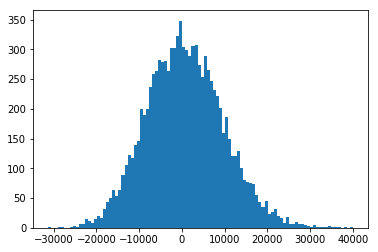

In [71]:
MCPnL = np.array(PnL)
MCPnL.sort
plt.hist(MCPnL, bins=100);
np.percentile(MCPnL, 5)
option_var = np.percentile(MCPnL, 5)

In [68]:
#historical Sim of shares 

'''share_list_name = ('BHP', 'RIO', 'CBA', 'WESP', 'WPL', 'NAB', 'TLS')

Hist_share_returns = pd.DataFrame()
for x in share_list_name:
    Hist_share_returns[x] = sharedata[x]
    
#calc returns
Hist_share_returns = np.log(Hist_share_returns).diff()
#drop first row NaN 
Hist_share_returns = (Hist_share_returns.drop(Hist_share_returns.index[0]))

#simulated price change 
Sim_price_change = Hist_share_returns * [38.78,94.77,81.88,38.86,33.81,28.51,3.98]

#Spot + sim price change 
HS_Sim_Price = Sim_price_change + [38.78,94.77,81.88,38.86,33.81,28.51,3.98]'''

#Short poitions
shorts = ['WESP', 'NAB', 'TLS']

for y in shorts:
    MC_sim_price[y] = MC_sim_price[y].apply(lambda x: x*-1)

#Portfolio 
MC_Port = MC_sim_price * [5000,3000,4000,10000,5000,15000,30000]
#Sim portfolio - portfolio 
#PnL_stock = pd.DataFrame(MC_Port.sum(axis=1)- 39130)

In [69]:
PnL_stock = pd.DataFrame(MC_Port.sum(axis=1)- 39130)
PnL_stock

,0
0,-10485.632862
1,-5028.577388
2,6672.645953
3,12615.340268
4,-12913.712108
5,12170.233412
6,132.873043
7,3937.095353
8,6043.276754
9,-3203.134729


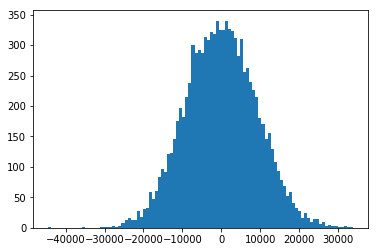

In [72]:
MCPnL = np.array(PnL_stock)
MCPnL.sort
plt.hist(MCPnL, bins=100);
np.percentile(MCPnL, 5)
stock_var = np.percentile(MCPnL, 5)

In [10]:
stock_var + option_var

-27899.985670686903

In [73]:
option_var

-13382.359408998716

In [74]:
stock_var

-14993.983180661073